# A.2: Train single linear block on EMNIST covariance

In [1]:
import torch
import coupling_bound as cb
import matplotlib.pyplot as plt
import FrEIA as fr
from tqdm.notebook import tqdm

from pathlib import Path

In [2]:
cmaps = {
    "diverging": "bwr",
    "standard": "viridis"
}

markersize = 1
markerscale = 8

fig_width = 12
fig_dir = Path.cwd() / "figs"
fig_dir.mkdir(exist_ok=True)

## Data

In [3]:
dataset_root = Path.cwd()

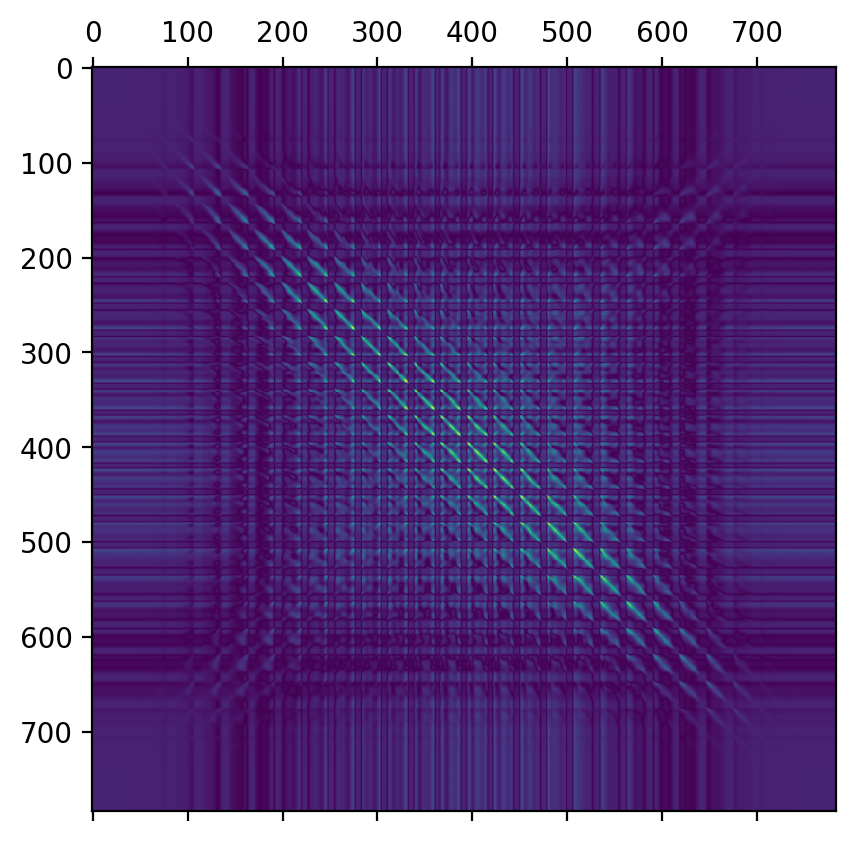

In [4]:
cov_in = cb.data.dataset_cov("EMNIST", .1, dataset_root)
plt.matshow(cov_in.abs())

## Covariance after Single Coupling Block

#### Prediction from theory

In [5]:
dim = cov_in.shape[0]
cov_out = cb.empiric.apply_layer(dim // 2, cov_in, s=True, t=True, sp=True)

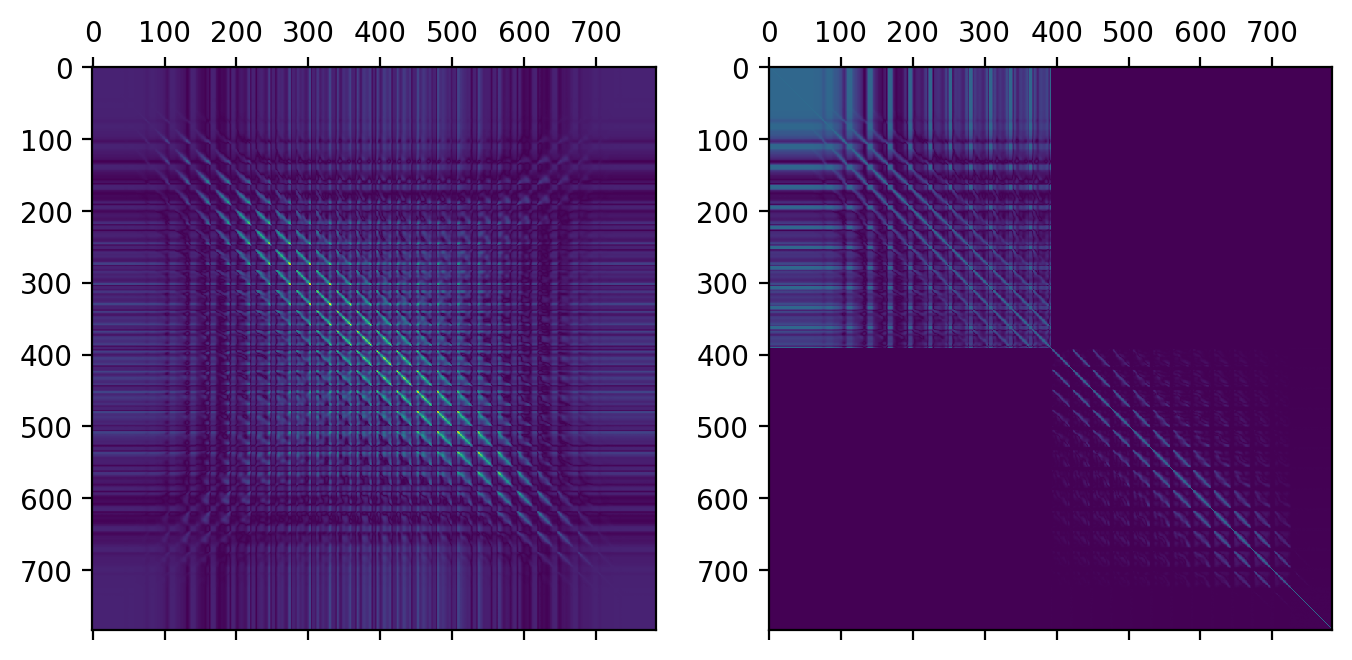

In [6]:
amplitude = max(torch.max(torch.abs(cov_in)), torch.max(torch.abs(cov_out)))

for cov in cb.vis.iter_ax_grid([cov_in, cov_out]):
    plt.matshow(cov.abs(), fignum=0, cmap=cmaps["standard"], vmin=0, vmax=amplitude)

### Experiment: Gaussian MNIST

#### Model: Linear coupling block

In [7]:
class LinearParamNet(torch.nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner
        assert len(self.inner) == 1

    def forward(self, x):
        # Linear in p
        params_linear = self.inner(x)
        # Constant in p
        params_constant = self.inner(torch.zeros_like(x))

        param_len = params_linear.shape[1] // 2
        s = params_constant[:, :param_len]
        t = params_linear[:, param_len:]

        new_params = torch.cat([s, t], 1)
        return new_params

In [8]:
def linear_subnet(dims_in, dims_out):
    return LinearParamNet(torch.nn.Sequential(
        torch.nn.Linear(dims_in, dims_out)
    ))

In [9]:
model = fr.modules.AllInOneBlock([[dim]], subnet_constructor=linear_subnet)
# Do not rotate
model.w_perm.data = model.w_perm_inv.data = torch.eye(dim)

In [10]:
losses = []

#### Train

In [11]:
# Train
optim = torch.optim.Adam(model.parameters(), lr=.05)

In [12]:
L = torch.linalg.cholesky(cov_in)
(L @ L.T - cov_in).abs().max()

tensor(1.5497e-06)

In [13]:
batch_size = 2 ** 11

try:
    with tqdm(range(2 ** 9)) as pbar:
        for _ in pbar:
            # for _ in range(64):
            optim.zero_grad()
            x = (L.float() @ torch.randn(dim, batch_size)).T
            (z,), jac = model([x], jac=True, rev=False)
            loss = (z ** 2).sum(-1).mean() / 2 - jac.mean()
            losses.append(loss.item())
            pbar.set_description(f"{loss.item():.1f}")
            loss.backward()
            optim.step()
except KeyboardInterrupt:
    pass

  0%|          | 0/512 [00:00<?, ?it/s]

-46.59550537109375

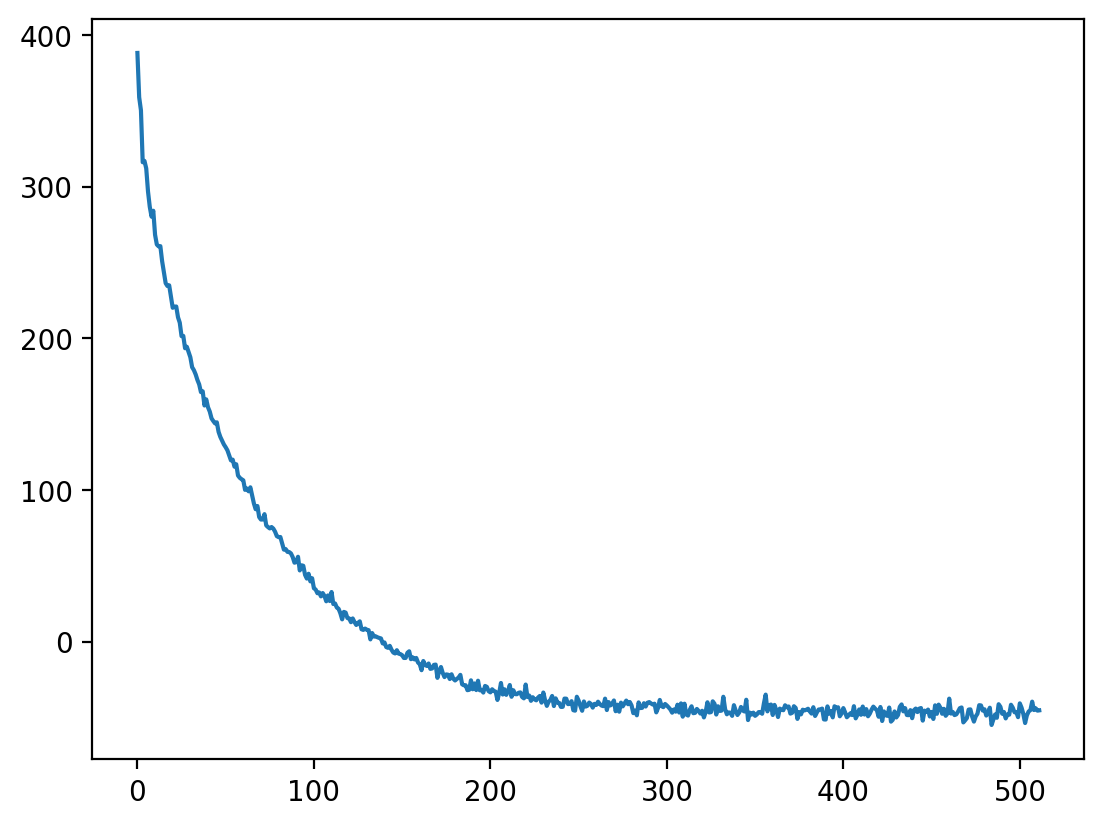

In [14]:
plt.plot(losses)
sum(losses[-100:]) / 100

#### Predict

In [15]:
with torch.no_grad():
    x = (L.float() @ torch.randn(dim, 2 ** 13)).T
    (z,), _ = model([x], jac=False, rev=False)
    cov_out_emp = torch.cov(z.T)

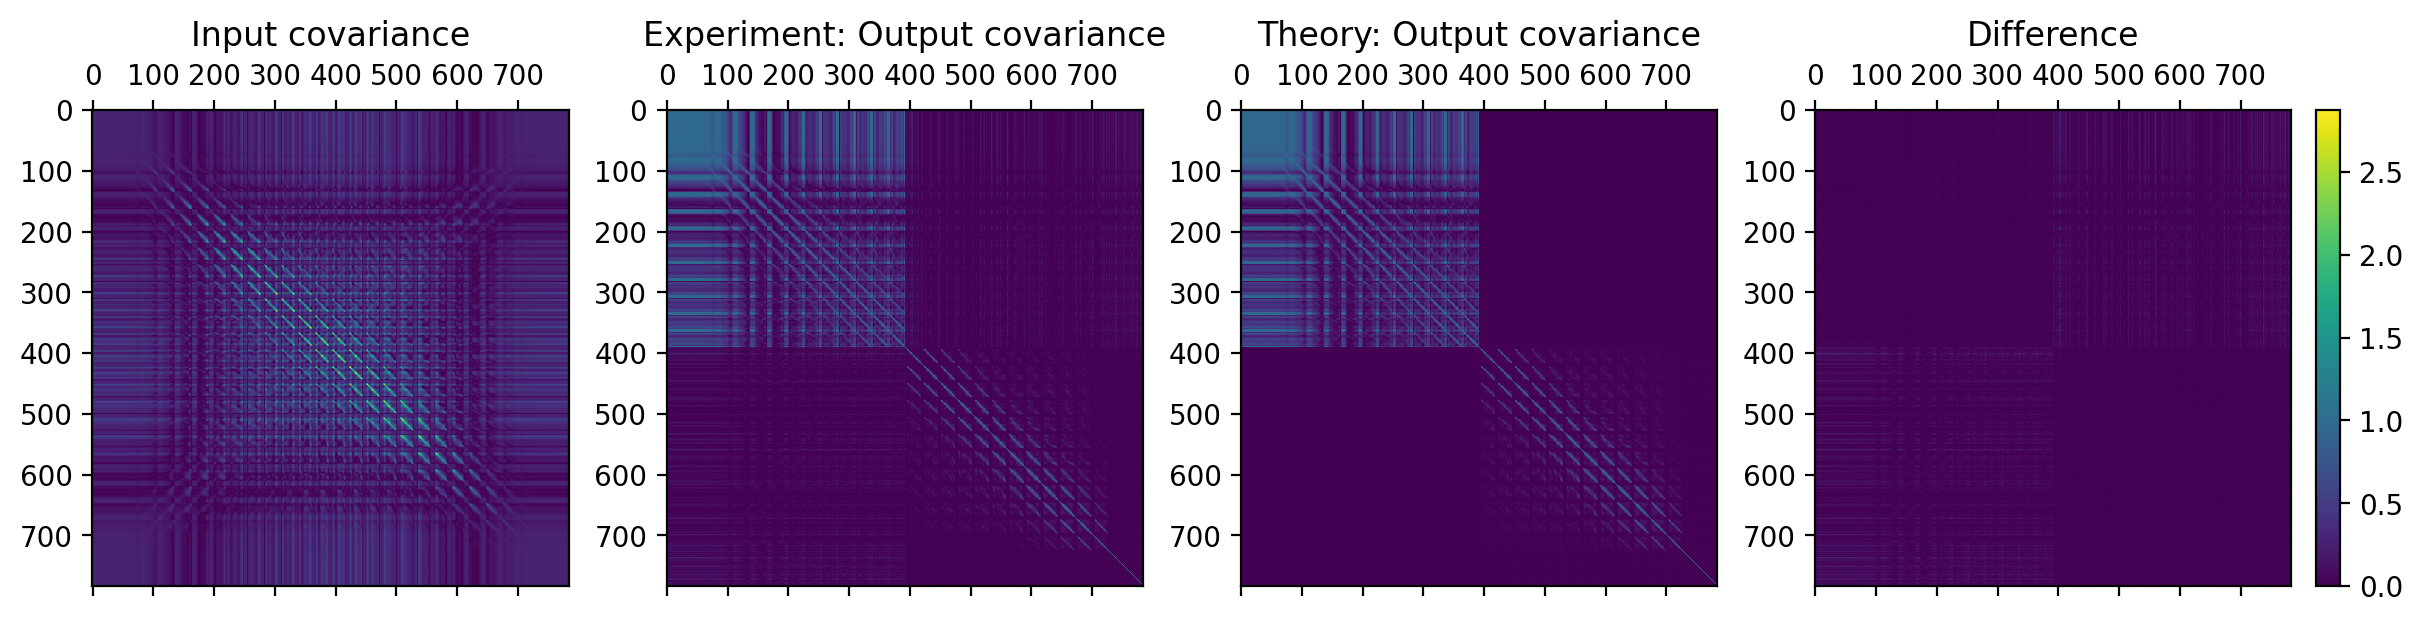

In [16]:
covs = [cov_in, cov_out_emp, cov_out, cov_out_emp - cov_out]
amplitude = torch.stack(covs, 0).abs().max()

for title, cov in zip(
    ["Input covariance", "Experiment: Output covariance", "Theory: Output covariance", "Difference"],
    cb.vis.iter_ax_grid(covs, constrained_layout=True, ncols=None, figsize=(fig_width, fig_width / 4))
):
    plt.title(title)
    plt.matshow(cov.abs(), fignum=0, vmin=0, vmax=amplitude, cmap=cmaps["standard"])

plt.colorbar()
plt.savefig(fig_dir / "emnist-single-layer-covariance.pdf", bbox_inches=0)